In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:

# %cd /content/drive/MyDrive/Colab\ Notebooks

In [3]:


# %ls

# Naive PPO for Hedging

In [2]:
import os #PS: explain os module?
from typing import Tuple
from typing import Type
from typing import Optional
import numpy as np
import pandas as pd
import torch as T  #PS: explain or reference online resources for pytorch
import torch.nn as nn
import torch.nn.functional as F  #PS: this may be advanced concept, explain or footnote
import torch.distributions as D
from torch import optim  #PS: what is the optimization algorithm in pytorch?  Any description needed?
import matplotlib.pyplot as plt
import copy  #PS: OK I don't know this one.  Will research

Utility Functions
-----------------
For the sake of ordered execution, we place the utility functions at first

`fetch_options` - fetch the option data from bucket storage. sample usage `fetch_option("AAPL", mrange=((2019,5),(2019,7)))`
preprocess is also supported. Simply provides a function `f` to manipulate the raw dataframe, `f: pd.DataFrame -> pd.DataFrame`

`load_frames` - helper function for `fetch_options`

In [3]:
def load_frames(paths,ticker=None,preprocess = lambda x: x):
    #PS: simply loads a data frame from csv file, which has a list of tickers.
    #PS: load_frames is a helper function for function fetch_options below
    r = []
    for path in paths:
        tmp = pd.read_csv(path)
        if ticker is not None:
            tmp = tmp[tmp["Ticker"] == ticker]
        r += [preprocess(tmp)]

    return r

def fetch_option(ticker, mrange=((2019,1),(2021,7)), preprocess = lambda x: x):
    __Base = "gs://hightouch-test-data/standard-ohlc-daily"
    names = []
    for y in range(mrange[0][0],mrange[1][0]+1):
        #PS: mrange is a tuple of tuples of beginning year and month and ending year and month
        names += [str(y)+'_'+f'{m:02}'+".csv" for m in range(1,13) if not (((y == mrange[0][0]) and (m < mrange[0][1])) or ((y == mrange[1][0]) and (m >= mrange[1][1])))]

    d = [os.path.join(__Base,name) for name in names]  #PS: d is the path is the csv files
    r = load_frames(d,ticker,preprocess) 
    return pd.concat(r,ignore_index=True)

In [4]:
! pip install py_vollib  #PS: should briefly describe and reference py_vollib

ERROR: Invalid requirement: '#PS:'


In [5]:
#PS: list of py_vollib greeks functions plus implied_volatility
from py_vollib.black_scholes_merton.greeks.analytical import delta
from py_vollib.black_scholes_merton.greeks.analytical import gamma
from py_vollib.black_scholes_merton.greeks.analytical import theta
from py_vollib.black_scholes_merton.greeks.analytical import vega
from py_vollib.black_scholes_merton.greeks.analytical import rho
from py_vollib.black_scholes_merton.greeks.numerical import delta as ndelta
from py_vollib.black_scholes_merton.greeks.numerical import gamma as ngamma
from py_vollib.black_scholes_merton.greeks.numerical import theta as ntheta
from py_vollib.black_scholes_merton.greeks.numerical import vega as nvega
from py_vollib.black_scholes_merton.greeks.numerical import rho as nrho
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility

In [5]:
from heston import Heston  #PS: not sure if we need Heston for the book.  Will see.

Policy Net -- The Main Model
----------------------------

### Initialization Parameters
---

`state_dim`: the dimension of state space, length of input 1d-tensor

`act_dim`: the dimension of action space, note this is not the same as length of the output of this network

`lr`: learning rate, default = 0.001

`dr`: drop-out rate, default = 0.2

`model_dir`: directory which the model file will output(save) to

`name`: network name, will used when saving/loading the model

### forward
---
forward propagation of policy net

`state`: input tensor/states, tensor of size = state_dim

returns tensor of size $2 \times act\_dim$, describes the distribution of policy-preferred action, e.g. for $act\_dim = 2$, output is $\begin{pmatrix}\mu_1 \\ \mu_2 \\ \sigma_1 \\ \sigma_2 \end{pmatrix}$ , which corresponds to actions -- $\begin{pmatrix} A_1 \\ A_2 \end{pmatrix} \sim \begin{pmatrix} \mathcal{N}(\mu_1,\sigma_1) \\ \mathcal{N}(\mu_2,\sigma_2) \end{pmatrix}$

Thus, we are assuming the action made has no correlation; for future development, consider to use multivariate normal distribution (built in pytorch).
With this independent assumption, we calculate logp by `distribution.log_prob(act).sum(axis=-1)`

> **_NOTE :_**  the forward propagation is natively overloaded with parenthesis operator, e.g. for `p = PolicyNet(s,a)`, `p.forward(state)` is equivalent to `p(state)`

### sample
---
sample from the action space based on the distribution outputted by the neural network (for training purpose)

`state`: input tensor/states, tensor of size = state_dim (passed to forward directly)

returns a reparameterized sample from the distribution indicated by the ouput of forward propagation of the network

### logp
---
Calculate the logprob of certain action given the state.

`state`: input tensor/states, tensor of size = state_dim
`act`: input tensor/actions, tensor of size = act_dim

return the log probability of certain action wrto the current parameters of `PolicyNet` instance

### evaluate
---
fetch the exploited action based on policy trained (for evaluation purpose, i.e. no exploring)

`state`: input tensor/states, tensor of size = state_dim (passed to forward directly)

returns the mean of outputted action distribution and 95% interval


### save/load
---
save/load the model for future uses (save to `model_dir` which indicated when the model initializes)

`suffix`: the file to saved/load with name `name`+`suffix`, i.e. for a model with `name = "PPO"` and `suffix = "_2023-01-01"`, `model_dir="./model"`, the output file will be `./model/PPO_2023-01-01`


In [6]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim, act_dim, lr=0.0001, dr=0.2, model_dir="./model", name="Policy"):
        super(PolicyNet, self).__init__()

        self.state_dim = state_dim
        self.act_dim = act_dim
        self.lr = lr
        self.model_dir = model_dir
        self.name = name
        self.checkpoint_file = os.path.join(self.model_dir, name)

        self.fcin = nn.Linear(state_dim, 512)
        # self.bn = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fcout = nn.Linear(512, act_dim*2) #for each dimension, we determine the mean and log(std) of the action (*2)
        self.fctest = nn.Linear(1, act_dim*2) #debug use
        self.drp = nn.Dropout(p=dr)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.double()#precision - double
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)


    def forward(self, state):
        x = state.double()#precision - double
        x = F.relu(self.fcin(x)) #no batch in simulation
        x = self.drp(x)
        x = F.relu(self.fc1(x))
        x = self.drp(x)
        x = F.relu(self.fc2(x))
        x = self.drp(x)
        x = self.fcout(x)

        return x

    def sample(self, state):
        x = self.forward(state)
        mu, lsig = x.split(self.act_dim)
        # print(lsig)
        assert not T.any(T.isinf(lsig)), f"{state} {lsig}"
        assert not T.any(T.isnan(lsig)), f"{state} {lsig}"
        # d = D.normal.Normal(mu,T.exp(lsig)) #log of std is trained instead so that the network output with full range, use exp to recover sig
        # d = D.normal.Normal(mu,0.1)#fix std for now
        d = D.normal.Normal(T.tanh(mu),T.sigmoid(lsig)+1e-12) #variance \in (0,1)
        sample = d.rsample()

        return sample, d.log_prob(sample).sum(axis=-1) #DONE: return logp also?

    def logp(self, state, act):
        x = self.forward(state)
        mu, lsig = x.split(self.act_dim,dim=-1)
        # print(mu, lsig)
        assert not T.any(T.isinf(lsig)), f"{state} {lsig}"
        assert not T.any(T.isnan(lsig)), f"{state} {lsig}"
        # d = D.normal.Normal(mu,T.exp(lsig))
        # d = D.normal.Normal(mu,0.1)
        d = D.normal.Normal(T.tanh(mu),T.sigmoid(lsig)+1e-12) #variance \in (0,1)

        return d.log_prob(act).sum(axis=-1), d.entropy()

    def evaluate(self, state):
        x = self.forward(state)
        mu, lsig = x.split(self.act_dim)
        return mu, -2.5066-lsig

    def save(self, suffix=""):
        print(f'... saving {self.name+suffix} ...')
        T.save(self.state_dict(), self.checkpoint_file+suffix)

    def load(self, suffix=""):
        print(f'... loading {self.name+suffix} ...')
        self.load_state_dict(T.load(self.checkpoint_file+suffix))



In [7]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as D

class PolicyNet(nn.Module):
    def __init__(self, state_dim, act_dim, lr=0.0001, dr=0.2, model_dir="./model", name="Policy"):
        super(PolicyNet, self).__init__()

        self.state_dim = state_dim
        self.act_dim = act_dim
        self.lr = lr
        self.model_dir = model_dir
        self.name = name
        self.checkpoint_file = os.path.join(self.model_dir, name)

        # Define transformer parameters
        self.embedding_dim = 512  # Must match the hidden dimension
        self.num_heads = 8
        self.num_layers = 2
        self.dropout = 0.1

        # Initial fully connected layers
        self.fcin = nn.Linear(state_dim, self.embedding_dim)

        # Define Transformer Encoder
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embedding_dim,
            nhead=self.num_heads,
            dim_feedforward=self.embedding_dim * 4,
            dropout=self.dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_encoder_layer,
            num_layers=self.num_layers
        )

        # Additional layers after transformer
        self.fc1 = nn.Linear(self.embedding_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fcout = nn.Linear(512, act_dim * 2)  # for each dimension, we determine the mean and log(std) of the action (*2)
        self.fctest = nn.Linear(1, act_dim * 2)  # debug use
        self.drp = nn.Dropout(p=dr)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.double()  # precision - double
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Ensure state is (batch_size, sequence_length, feature_dim)
        x = state.double()  # precision - double
        x = F.relu(self.fcin(x))
        # Transpose to (sequence_length, batch_size, feature_dim)
        x = x.permute(1, 0, 2)
        # Pass through transformer encoder
        x = self.transformer_encoder(x)
        # Transpose back to (batch_size, sequence_length, feature_dim)
        x = x.permute(1, 0, 2)
        x = F.relu(self.fc1(x[:, -1]))  # Use the output from the last sequence step
        x = self.drp(x)
        x = F.relu(self.fc2(x))
        x = self.drp(x)
        x = self.fcout(x)

        return x

    def sample(self, state):
        x = self.forward(state)
        mu, lsig = x.split(self.act_dim, dim=-1)
        assert not T.any(T.isinf(lsig)), f"{state} {lsig}"
        assert not T.any(T.isnan(lsig)), f"{state} {lsig}"
        d = D.normal.Normal(T.tanh(mu), T.sigmoid(lsig) + 1e-12)  # variance ∈ (0,1)
        sample = d.rsample()

        return sample, d.log_prob(sample).sum(axis=-1)  # DONE: return logp also?

    def logp(self, state, act):
        x = self.forward(state)
        mu, lsig = x.split(self.act_dim, dim=-1)
        assert not T.any(T.isinf(lsig)), f"{state} {lsig}"
        assert not T.any(T.isnan(lsig)), f"{state} {lsig}"
        d = D.normal.Normal(T.tanh(mu), T.sigmoid(lsig) + 1e-12)  # variance ∈ (0,1)

        return d.log_prob(act).sum(axis=-1), d.entropy()

    def evaluate(self, state):
        x = self.forward(state)
        mu, lsig = x.split(self.act_dim, dim=-1)
        return mu, -2.5066 - lsig

    def save(self, suffix=""):
        print(f'... saving {self.name+suffix} ...')
        T.save(self.state_dict(), self.checkpoint_file + suffix)

    def load(self, suffix=""):
        print(f'... loading {self.name+suffix} ...')
        self.load_state_dict(T.load(self.checkpoint_file + suffix))


Baseline Net
------------

The auxiliary network to estimate the value function on the given state space. The parameters are simimar to Policy Net above.

In [8]:
class BaselineNet(nn.Module):
    def __init__(self, state_dim, lr=0.0001, dr=0.2, model_dir="./model", name="Baseline"):
        super(BaselineNet, self).__init__()

        self.state_dim = state_dim
        self.lr = lr
        self.model_dir = model_dir
        self.name = name
        self.checkpoint_file = os.path.join(self.model_dir, name)

        self.fcin = nn.Linear(state_dim, 512)
        # self.bn1 = nn.BatchNorm1d(512)
        # self.bn2 = nn.BatchNorm1d(512)
        # self.bn3 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fcout = nn.Linear(512, 1) #for each dimension, we determine the mean and log(std) of the action (*2)
        self.drp = nn.Dropout(p=dr)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = state.double()
        x = F.relu(self.fcin(x))
        x = self.drp(x)
        x = F.relu(self.fc1(x))
        x = self.drp(x)
        # x = self.bn3(F.relu(self.fc2(x)))
        # x = self.drp(x)
        x = self.fcout(x)
        return x

    def save(self, suffix=""):
        print(f'... saving {self.name+suffix} ...')
        T.save(self.state_dict(), self.checkpoint_file+suffix)

    def load(self, suffix=""):
        print(f'... loading {self.name+suffix} ...')
        self.load_state_dict(T.load(self.checkpoint_file+suffix))

The Virtual Environment
---------------------

### Initialization
---
Parameters are used for `PolicyNet` and `BaselineNet` initialization (please refer to previous sections).
Initializes `PolicyNet` and `BaselineNet`


### reset
---
Implementation requred in the inheritted classes.
> **_Functionality :_**  reset the environment to a start/random state; clear cache; prepare for new simulation trial.
> **_Note :_**  **MUST** set `self.state = None`

### evolve
---
Implementation requred in the inheritted classes.

`action`: tensor of size `act_dim`
returns old state, reward of single step action, whether the environment is done (no further action can be taken/expired/simulation completed)
> **_Functionality :_**  move the environment forward one step based on the action provided; update `self.state`

### simulate
---
`max_len`: $\mathbb{Q}_+ \cup \{\infty\}$, maximum length of trajectory to return
`max_iter`:$\mathbb{Q}_+ \cup \{\infty\}$, maximum steps to simulate

returns the simulated trajectory, `traj{"state","act","logp","reward"}`
> **_Note :_**  the returned dictionary is supposed to have same structure as the `self.batch` dictionary initialized.

### objective
---
Implementation requred in the inheritted classes.

`batch`: the simulated batch dictionary
returns the loss tensor with `require_grad = True`
> **_Functionality :_** the objective function for PolicyNet(e.g. PPO)

### optimize
---
optimize the PolicyNet and BaselineNet one step forward. requires `self.objective` to be implemented.

`batchsize`: the size of training batch
returns `self`
> **_DONE :_** Do several iterations of optimization for each network in one epoch, add the control parameter for this (Test this)
> **_TODO :_** convert the batch lists into Torch Tensor before optimizing to avoid device overhead

### score
---
Implementation requred in the inheritted classes.

`batch`: the simulated batch dictionary
returns the float valued score of given batch

> **_Functionality :_** evaluate the policy performance in a more visualizable manner (compared to `self.objective`).

### evaluate
---
evaluate the policy performance. requires `self.objective` and `self.score` to be implemented.

`batch`: the simulated batch dictionary
returns float valued loss and score

### train
---
training the embedded networks (PolicyNet and BaselineNet).

`epochs`: $\mathbb{Z}_+$, iterations of optimization
`train_batchs`: $\mathbb{Z}_+$, size of training batch
`val_batchs`: $\mathbb{Z}_+$, size of validation batch
`verbose`: $\{0,1,2\}$, level of logging, 0 - no log, 1 - last activity, 2 - print all

### export
---
`suffix`: string, optional, suffix of model file to save, will export to `model` directory if specified.
returns `PolicyNet` and `BaselineNet`, or copy of them.

### load
---
`PolicyNet`: policy model to load
`BaselineNet`: Baseline model to load

Overload -
`suffix`: string, optional, suffix of model file to load, will load from `model` directory if specified.

returns `PolicyNet` and `BaselineNet`, or copy of them.

In [9]:
class Reinforecement(nn.Module):
    def __init__(self, state_dim, act_dim, eps=0.2, lr=0.0001, dr=0.2, gamma=0.99, lam=0.95, bufsize=4096, rollsize=256, model_dir="./model"):
        super(Reinforecement, self).__init__()

        self.eps = eps
        self.state_dim = state_dim
        self.act_dim = act_dim

        self.gamma = gamma
        self.lam = lam
        self.pho = np.exp(np.log(0.1) / (bufsize/rollsize-1))

        self.state = None #T.tensor.new_empty(state_dim)

        self.replaybuffer = {}
        self.buffersize = bufsize
        self.rollsize = rollsize

        self.policy = PolicyNet(state_dim, act_dim, lr, dr, model_dir=model_dir, name="Policy").double() #change precision here
        self.baseline = BaselineNet(state_dim, lr, dr, model_dir=model_dir, name="Baseline").double()

        self.mse = nn.MSELoss() # initialize once to train baseline

        self.epochs = 0
        self.best = -np.inf
        self.trainloss = []
        self.trainscore = []
        self.validloss = [] #per epoch
        self.validscore = []

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    #TODO: remember to deal with self.state=None (note in doc)
    def reset(self):
        raise NotImplementedError

    def evolve(self, action) -> Tuple[T.Tensor, T.Tensor, bool]: #virtual: outputs old_state, reward/loss, done ; update current state internally
        raise NotImplementedError

    def simulate(self, max_len=np.inf, max_iter=np.inf, eval=False):
        traj = {}
        traj['state'] = []
        traj['act'] = []
        traj['logp'] = []
        # traj['entropy'] = []
        traj['reward'] = []
        traj['rtg'] = [] #reward to go
        

        done = False
        length = 0
        self.reset()

        while (not done) and (length < max_iter): #simulate one step forward with `evolve`
            traj['state'] += [self.state]
            if not eval:
                act, logp = self.policy.sample(self.state)
            else:
                act, logp = self.policy.evaluate(self.state) #TODO: change logp to some kind of interval accordingly

            # act = full_range(act)

            traj['act'] += [act]
            traj['logp'] += [logp]
            _, reward, done = self.evolve(act)
            # print(done)
            traj['reward'] += [reward]
            length += 1

        traj['rtg'] = [0 for i in range(length)]
        for i in reversed(range(length)):
            traj['rtg'][i] = traj['reward'][i].detach() + self.gamma*(0 if (i+1 >= length) else traj['rtg'][i+1])
            
        self.baseline.eval()
        val = self.baseline(T.stack(traj["state"])).detach()
        traj['value'] = val
        
        
        # GAE advantage
        
        delta = [0 for i in range(length)]
        for i in reversed(range(length)):
            delta[i] = traj['reward'][i].detach() - val[i] + self.gamma*(0 if (i+1 >= length) else val[i+1])
        
        f = self.lam * self.gamma
        traj['advantage'] = [0 for i in range(length)]
        for i in reversed(range(length)):
            traj['advantage'][i] = delta[i] + f*(0 if (i+1 >= length) else traj['advantage'][i+1])
        
        traj['weight'] = T.ones_like(val)

        for k in ('state', 'act', 'logp', 'reward', 'rtg', 'value', 'advantage', 'weight'):
            traj[k] = traj[k][:min(length,max_len)]

        return traj, min(length,max_len)

    def objective(self, batch: dict) -> T.tensor:
        raise NotImplementedError

    def optimize(self, batch_size, iterations):
        #moved from initialization to here since cannot share through batchs (need to be initialized empty each epoch)
        batch = {}
        batch['state'] = []
        batch['act'] = [] #Note: we dont need to store action here if logprob is stored, however, lets keep it here for future changes.(state is necessary for baseline training
        batch['logp'] = []
        batch['reward'] = []
        batch['rtg'] = [] #reward to go
        batch['value'] = []
        batch['advantage'] = []
        batch['weight'] = []
        #DONE: How to implement reparameterized sample action in a batch without breaking the gradient graph?
        #Solution foureplaybufferuse expanding list to store variable with gradient (do not preallocate). List Append definitely works; for our convenience, lets try += here and see if it works

        counter = 0

        # fetch the batch through simulation
        while counter < batch_size:
            #print(batch_size)
            #print(counter)
            t, l = self.simulate(max_len= batch_size - counter) #set eval=True for debug the network (using mean only)
            for k in ('state', 'act', 'logp', 'reward', 'rtg', 'value', 'advantage', 'weight'):
                batch[k] += t[k]
            counter += l
            
        if 'weight' in self.replaybuffer:
            self.replaybuffer['weight'] *= self.pho

        for k in ('state', 'act', 'logp', 'reward', 'rtg', 'value', 'advantage', 'weight'):
            
            batch[k] = T.stack(batch[k])
            
            if k not in self.replaybuffer:
                self.replaybuffer[k] = batch[k]
            else:
                self.replaybuffer[k] = T.cat([self.replaybuffer[k],batch[k]])
            self.replaybuffer[k] = self.replaybuffer[k][-self.buffersize:]
        
        

        # Already detached!: batch['rtg'] = batch['rtg'].detach() #otherwise will re-use model graph
        # print(batch["state"])

#         merge these two training step into one
#         #optimize baseline net
#         self.baseline.train()
#         for i in range(iterations):
#             rw = self.baseline(batch["state"]) #DEBUG: batch input
#             loss = self.mse(rw, batch["rtg"])
#             self.baseline.optimizer.zero_grad()
#             loss.backward()
#             self.baseline.optimizer.step()

#         self.baseline.eval()

#         #DONE: add baseline calculation here (detached)
#         val = self.baseline(batch["state"])
#         batch['value'] = val.detach()

#         # optimize policy net; DONE: Consider to add multiple step descend for each iteration
#         for i in range(iterations): #DEBUG: Something is re-using!
#             # print(i)
#             loss = self.objective(batch)
#             self.policy.optimizer.zero_grad()
#             loss.mean().backward()
#             self.policy.optimizer.step()

        for i in range(iterations):
            # print(i)
            self.baseline.train()
            rw = self.baseline(self.replaybuffer["state"]) #DEBUG: batch input
            loss = self.mse(rw, self.replaybuffer["rtg"])
            self.baseline.optimizer.zero_grad()
            loss.backward()
            self.baseline.optimizer.step()

            # self.baseline.eval()
            # val = self.baseline(batch["state"])
            # batch['value'] = val.detach()

            loss = self.objective(self.replaybuffer)
            self.policy.optimizer.zero_grad()
            loss.mean().backward()
            self.policy.optimizer.step()


        # loss = self.objective(batch)
        # self.trainloss += [loss.sum().item()]
        # self.trainscore += [self.score(batch)]

        return self

    def score(self, batch:dict) -> float:
        raise NotImplementedError
        
        
    def get_eval_batch(self, batch_size=512):
        
        # TODO: should make this abstract function in the future
        batch = {}
        batch['state'] = []
        batch['act'] = [] #Note: we dont need to store action here if logprob is stored, however, lets keep it here for future changes.(state is necessary for baseline training
        batch['logp'] = []
        batch['reward'] = []
        batch['rtg'] = [] #reward to go
        batch['value'] = []
        batch['advantage'] = []
        #DONE: How to implement reparameterized sample action in a batch without breaking the gradient graph?
        #Solution foureplaybufferuse expanding list to store variable with gradient (do not preallocate). List Append definitely works; for our convenience, lets try += here and see if it works
        
        counter = 0

        # fetch the batch through simulation
        while counter < batch_size:
            t, l = self.simulate(max_len=batch_size-counter) #set eval=True for debug the network (using mean only)
            for k in ('state', 'act', 'logp', 'reward', 'rtg', 'value', 'advantage'):
                batch[k] += t[k]
            counter += l

        for k in ('state', 'act', 'logp', 'reward', 'rtg', 'value', 'advantage'):
            batch[k] = T.stack(batch[k])
        
        return batch

    def evaluate(self, batch_size=512):
        
        eval_batch = self.get_eval_batch(batch_size)
        # compute loss and score
        loss = self.objective(eval_batch)
        score = self.score(eval_batch)

        return loss.mean().item(), score

    def train(self, epochs=100, train_iterations=8, val_batchs=512, save_epochs=10, verbose=2):
        
        for i in range(epochs):
            self.optimize(self.rollsize, train_iterations)
            loss, score = self.evaluate(val_batchs)
            # print((score, self.best))
            if (score > self.best) and (self.epochs > 1):
                self.best = score
                self.export(suffix="_best")

            if (self.epochs % save_epochs == 0):
                self.export(suffix=f"_save_{self.epochs}")
                
            tloss = self.objective(self.replaybuffer).mean().item()
            tscore = self.score(self.replaybuffer)

            if verbose == 2:
                print("Epoch",i+1,":",f"valid - loss: {loss}, score: {score}; insample - loss: {tloss}, score: {tscore}")
            elif verbose == 1:
                print("Epoch",i+1,":",f"valid - loss: {loss}, score: {score}; insample - loss: {tloss}, score: {tscore}", end='\r')

            self.validloss += [loss]
            self.validscore += [score]
            self.trainloss += [loss]
            self.trainscore += [score]

            self.epochs += 1

        return self


    def get_insample_loss(self):
        return copy.deepcopy(self.trainloss)

    def get_insample_score(self):
        return copy.deepcopy(self.trainscore)

    def get_validation_loss(self):
        return copy.deepcopy(self.validloss)

    def get_validation_score(self):
        return copy.deepcopy(self.validscore)

    def export(self, suffix : str = None):
        if suffix is None:
            return copy.deepcopy(self.policy), copy.deepcopy(self.baseline)
        else:
            self.policy.save(suffix=suffix)
            self.baseline.save(suffix=suffix)
        return self.policy, self.baseline

    def load(self, suffix : str = None, suffix_b : Optional[str] = None, policy : Optional[Type[PolicyNet]] = None, baseline : Optional[Type[BaselineNet]] = None):
        op, ob = copy.deepcopy(self.policy), copy.deepcopy(self.baseline)

        if suffix is None:
            self.policy, self.baseline = policy, baseline
        else:
            self.policy.load(suffix=suffix)
            self.baseline.load(suffix=suffix)
        return op, ob

In [10]:
class Environment(Reinforecement, nn.Module):
    def __init__(self, eps=0.2, lr=0.0001, dr=0.2, gamma=0.99, lam=0.95, entrpy_scaler=0.0001):

        state_dim = 4 #change this when incorporating more features
        act_dim = 1

        self.entrpy_scaler = entrpy_scaler

        super(Environment, self).__init__(state_dim, act_dim, eps=eps, lr=lr, dr=dr, gamma=gamma, lam=lam)

        # draw from a joint distribution in the future
        self.r = 0.007                                           # drift
        rho = 0.3                                         # correlation coefficient
        kappa = 30                                          # mean reversion coefficient
        theta = 0.13                                        # long-term mean of the variance
        sigma = 1.6                                       # (Vol of Vol) - Volatility of instantaneous variance
        
        self.Tunit = 1/252
        self.dt = self.Tunit/10
        self.model = Heston(self.r, kappa, theta, sigma, rho)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def reset(self):
        self.iat = 0
        self.v0 = 0.2                                          # spot variance
        self.S0 = 450                                            # spot stock price
        self.T = 20                                             # Terminal time
        self.K = 450	                                            # Stike

        self.option = self.model.price_put(self.S0, self.v0, self.K, self.T * self.Tunit, self.r)
        self.cash = self.option
        self.delta = 0
        
        self.w0 = self.cash

        self.moneyness = self.S0 / self.K - 1

        self.state = T.tensor([self.moneyness, np.sqrt(self.T * self.Tunit), self.delta, -0.5]).to(self.device)
        return

    def evolve(self, action) -> Tuple[T.Tensor, T.Tensor, bool]: #play with the data first
        oldstate = self.state.clone().detach()
        self.cash *= np.exp(self.r)
        self.cash -= self.S0 * (action[0].item() + np.abs(action[0].item() * 0.01))
        self.delta += action[0].item()
        self.iat += 1
        
        temp = [self.S0, self.option]
        #print(self.S0)
        #print(self.v0)
        #print(self.Tunit)
        #print(self.dt)
        self.S0, self.v0 = self.model.simulate_n(self.S0, self.v0, self.Tunit, self.dt)

        self.option = self.model.price_put(self.S0, self.v0, self.K, (self.T - self.iat) * self.Tunit, self.r)
        
        temp[0] = self.S0 - temp[0]
        temp[1] = self.option - temp[1]
        dd = temp[1] / temp[0]
        
        reward = T.minimum((T.tensor(self.cash + self.S0 * self.delta - self.option / self.w0) - 1.).to(self.device), T.zeros(1,dtype=T.double).to(self.device))
        # print(reward)

        done = False
        if (self.iat == self.T) or (reward.item() < -2):
            done = True
        else:
            self.moneyness = self.S0 / self.K - 1

            self.state = T.tensor([self.moneyness, np.sqrt((self.T - self.iat) * self.Tunit), self.delta, dd]).to(self.device)

        return oldstate, reward, done


    def objective(self, batch: dict) -> T.tensor:
        """
        for each epoch/call, detach the original logp; re-evaluate the new logp for exploitation ratio. evaluate the advantage for the updated network.
        modify the clip(pi/pi_k,1-eps,1+eps) to clip(logp-logp_k, -eps_1, +eps_2), eps1 = -log(1-eps), eps2 = log(1+eps)
        """
        # return - batch["reward"] # reparametrization trick
        #Note: detached act and logp to not re-use the graph
        logp, entropy = self.policy.logp(batch["state"],batch["act"].detach()) # get new act with requiregrad=True
        # print(T.min((logp-batch["logp"]) * (batch["rtg"] - batch["value"]), T.clamp(logp-batch["logp"],min=-np.log(1-self.eps),max=np.log(1+self.eps)) * (batch["rtg"] - batch["value"])))
    
    
        PPOLoss = T.minimum(T.exp(logp-batch["logp"].detach()) * (batch["advantage"]), T.clamp(T.exp(logp-batch["logp"].detach()),min=1-self.eps,max=1+self.eps) * (batch["advantage"]))
        # print(entropy, PPOLoss)
        # print(batch["rtg"] - batch["value"])
        #Note: minimize the negative PPO objective
        
        weight = 1.
        if "weight" in batch:
            weight = batch['weight']
        
        return weight * (- self.entrpy_scaler * entropy - PPOLoss)

    def score(self, batch:dict) -> float:
        
        if "weight" in batch:
            return T.sum(batch["reward"] * batch["weight"]) / T.sum(batch["weight"])
        return T.mean(batch["reward"]).item()


In [ ]:
np.random.multivariate_normal(np.zeros(2), np.array([[1,0.5], [0.5,1]]), size=(1,int(1/0.000396825)))

In [1]:
1/0.000396825

2520.0025200025198

In [11]:
agent = Environment()
agent.train()

C:\Users\thoma\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 3

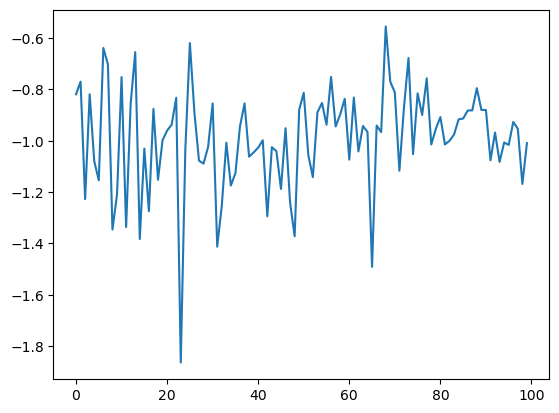

<Figure size 640x480 with 0 Axes>

In [28]:
#plt.figure(15, 10)
plt.plot(agent.get_validation_score())
plt.show()
plt.savefig("validscore.png")

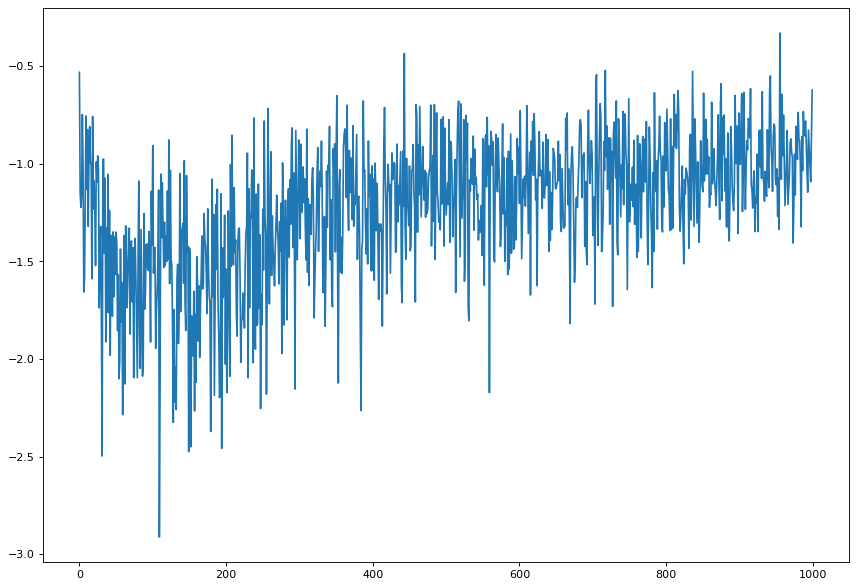

In [37]:
plt.figure(figsize=(13, 9), dpi=80)
plt.plot(agent.get_validation_score())
plt.savefig("validscore.png")

In [14]:
np.max(agent.get_validation_score())

-0.3293845513907268

In [15]:
p, _ = agent.export()

In [20]:
p(T.tensor([-0.5,np.sqrt(3/252),-0.3,-0.3]).to(p.device))

tensor([-0.0566,  0.0132], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)

### Analysis
---



In [26]:
#hot patch
def get_eval_batch(self, batch_size=512, eval=False):
        
    # TODO: should make this abstract function in the future
    batch = {}
    batch['state'] = []
    batch['act'] = [] #Note: we dont need to store action here if logprob is stored, however, lets keep it here for future changes.(state is necessary for baseline training
    batch['logp'] = []
    batch['reward'] = []
    batch['rtg'] = [] #reward to go
    batch['value'] = []
    batch['advantage'] = []
    #DONE: How to implement reparameterized sample action in a batch without breaking the gradient graph?
    #Solution foureplaybufferuse expanding list to store variable with gradient (do not preallocate). List Append definitely works; for our convenience, lets try += here and see if it works

    counter = 0

    # fetch the batch through simulation
    while counter < batch_size:
        t, l = self.simulate(max_len=batch_size-counter, eval=eval) #set eval=True for debug the network (using mean only)
        for k in ('state', 'act', 'logp', 'reward', 'rtg', 'value', 'advantage'):
            batch[k] += t[k]
        counter += l

    for k in ('state', 'act', 'logp', 'reward', 'rtg', 'value', 'advantage'):
        batch[k] = T.stack(batch[k])

    return batch

agent.get_eval_batch = get_eval_batch

In [38]:
testb = get_eval_batch(agent,batch_size=4096, eval=True)
testb

{'state': tensor([[ 0.0000,  0.2817,  0.0000, -0.5000],
         [-0.0050,  0.2746, -0.0485,  0.9025],
         [-0.0083,  0.2673, -0.1016, -1.1305],
         ...,
         [ 0.0251,  0.1890, -0.4808, -0.7641],
         [ 0.0361,  0.1782, -0.5261, -0.4690],
         [ 0.0084,  0.1667, -0.5670, -0.1924]], device='cuda:0',
        dtype=torch.float64),
 'act': tensor([[-0.0485],
         [-0.0532],
         [-0.0551],
         ...,
         [-0.0453],
         [-0.0409],
         [-0.0533]], device='cuda:0', dtype=torch.float64,
        grad_fn=<StackBackward0>),
 'logp': tensor([[-2.5063],
         [-3.1720],
         [-2.5074],
         ...,
         [-2.5164],
         [-2.5159],
         [-2.5450]], device='cuda:0', dtype=torch.float64,
        grad_fn=<StackBackward0>),
 'reward': tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]], device='cuda:0', dtype=torch.float64),
 'rtg': tensor([[0.],
         [0.],
         [0.],
         .

In [39]:
states = testb['state'].cpu().tolist()
acts = testb['act'].cpu().tolist()

In [40]:
import json
with open('state.json', 'w', encoding='utf-8') as f:
    json.dump(states, f, ensure_ascii=False, indent=4)

with open('act.json', 'w', encoding='utf-8') as f:
    json.dump(acts, f, ensure_ascii=False, indent=4)

### Note
In AAPL_option.csv, row 35473. Strike is 80, underlying is 86.33, ttm is 1 year, why is call price more than 270? This problem occurs in many other rows too.

RE: This is because the unadjusted equity price from Yahoo Finance is actually adjusted wrto stock split. To resolve this, use unadjusted equity ohlc from algoseek database in the future.

In [ ]:
agent = Agent()
agent.train()

Current experiment

In [ ]:
plt.plot(agent.get_validation_score())
plt.show()

### real simple result:

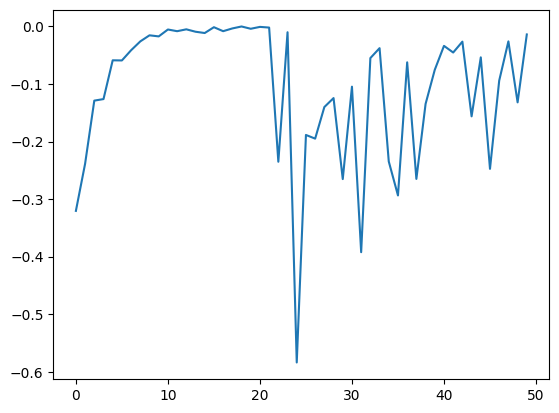

In [ ]:
plt.plot(agent.get_validation_score())
plt.show()

In [ ]:
p, _ = agent.export()

In [ ]:
p(T.tensor([0.1]).to(p.device))

tensor([ 0.2656, -1.9148], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)

### reparametrization trick sample training

In [ ]:
agent = Agent()
agent.train(train_iterations=1)

... saving Policy_save_0 ...
... saving Baseline_save_0 ...
Epoch 1 : loss: 34997.54204869617, score: -34997.54204869617
Epoch 2 : loss: 7657.308080126331, score: -7657.308080126331
... saving Policy_best ...
... saving Baseline_best ...
Epoch 3 : loss: 25603.896332265664, score: -25603.896332265664
... saving Policy_best ...
... saving Baseline_best ...
Epoch 4 : loss: 25185.787951205893, score: -25185.787951205893
... saving Policy_best ...
... saving Baseline_best ...
Epoch 5 : loss: 3671.3011862256817, score: -3671.3011862256817
Epoch 6 : loss: 12100.98900940453, score: -12100.98900940453
Epoch 7 : loss: 42460.81669695376, score: -42460.81669695376
Epoch 8 : loss: 5071.84327972264, score: -5071.84327972264
Epoch 9 : loss: 4301.4178773144795, score: -4301.4178773144795
Epoch 10 : loss: 7265.482438312798, score: -7265.482438312798
... saving Policy_save_10 ...
... saving Baseline_save_10 ...
Epoch 11 : loss: 21066.82625826388, score: -21066.82625826388
Epoch 12 : loss: 22876.15049481

Agent(
  (policy): PolicyNet(
    (fcin): Linear(in_features=1, out_features=512, bias=True)
    (fc1): Linear(in_features=512, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fcout): Linear(in_features=512, out_features=2, bias=True)
    (fctest): Linear(in_features=1, out_features=2, bias=True)
    (drp): Dropout(p=0.2, inplace=False)
  )
  (baseline): BaselineNet(
    (fcin): Linear(in_features=1, out_features=512, bias=True)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=512, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fcout): Linear(in_features=512, out_features=1, bias=True)
    (drp): Dropout(p=0.2, inplace=False)
  )
  (m

In [ ]:
agent.train(train_iterations=1)

... saving Policy_save_100 ...
... saving Baseline_save_100 ...
Epoch 1 : loss: 57763.616490312044, score: -57763.616490312044
Epoch 2 : loss: 13503.907172164894, score: -13503.907172164894
Epoch 3 : loss: 3373.767633699217, score: -3373.767633699217
Epoch 4 : loss: 23818.211682492918, score: -23818.211682492918
Epoch 5 : loss: 21698.91887071241, score: -21698.91887071241
Epoch 6 : loss: 3047.229444329573, score: -3047.229444329573
Epoch 7 : loss: 2549.8978903397915, score: -2549.8978903397915
Epoch 8 : loss: 2408.705459975763, score: -2408.705459975763
Epoch 9 : loss: 43948.12212618061, score: -43948.12212618061
Epoch 10 : loss: 20473.790745203507, score: -20473.790745203507
... saving Policy_save_110 ...
... saving Baseline_save_110 ...
Epoch 11 : loss: 32187.12495875501, score: -32187.12495875501
Epoch 12 : loss: 20344.892511663435, score: -20344.892511663435
Epoch 13 : loss: 19751.865326817726, score: -19751.865326817726
Epoch 14 : loss: 21321.83628526472, score: -21321.83628526472

Agent(
  (policy): PolicyNet(
    (fcin): Linear(in_features=1, out_features=512, bias=True)
    (fc1): Linear(in_features=512, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fcout): Linear(in_features=512, out_features=2, bias=True)
    (fctest): Linear(in_features=1, out_features=2, bias=True)
    (drp): Dropout(p=0.2, inplace=False)
  )
  (baseline): BaselineNet(
    (fcin): Linear(in_features=1, out_features=512, bias=True)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=512, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fcout): Linear(in_features=512, out_features=1, bias=True)
    (drp): Dropout(p=0.2, inplace=False)
  )
  (m

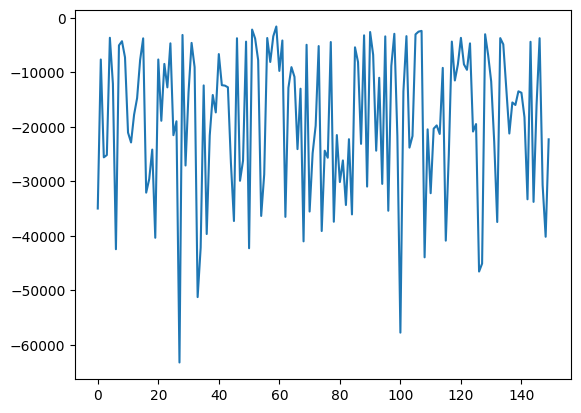

In [ ]:
plt.plot(agent.get_validation_score())
plt.show()

In [ ]:
p, _ = agent.export()

In [115]:
p(T.tensor([0.1,np.sqrt(1/252),0.1]).to(p.device))

tensor([  2.4183, -11.6193], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)

### PPO sample training result

In [ ]:
agent = Agent()
agent.train()

... saving Policy_save_0 ...
... saving Baseline_save_0 ...
Epoch 1 : loss: 9228853.355821371, score: -21260.920298121346
Epoch 2 : loss: 2406713.639280823, score: -6764.437017791451
... saving Policy_best ...
... saving Baseline_best ...
Epoch 3 : loss: 4588573.196559564, score: -12812.80776893249
... saving Policy_best ...
... saving Baseline_best ...
Epoch 4 : loss: 5042177.030255555, score: -12713.742272244539
... saving Policy_best ...
... saving Baseline_best ...
Epoch 5 : loss: 3591880.5603988487, score: -7464.462443304999
... saving Policy_best ...
... saving Baseline_best ...
Epoch 6 : loss: 1741643.0342365722, score: -6448.2513723472
... saving Policy_best ...
... saving Baseline_best ...
Epoch 7 : loss: 1956206.6905046848, score: -5285.864750284733
... saving Policy_best ...
... saving Baseline_best ...
Epoch 8 : loss: 1281874.578756667, score: -4795.586956150851
Epoch 9 : loss: 2403403.2332180347, score: -6678.038448865945
Epoch 10 : loss: 3881409.860847993, score: -9579.73

Agent(
  (policy): PolicyNet(
    (fcin): Linear(in_features=1, out_features=512, bias=True)
    (fc1): Linear(in_features=512, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fcout): Linear(in_features=512, out_features=2, bias=True)
    (fctest): Linear(in_features=1, out_features=2, bias=True)
    (drp): Dropout(p=0.2, inplace=False)
  )
  (baseline): BaselineNet(
    (fcin): Linear(in_features=1, out_features=512, bias=True)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=512, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fcout): Linear(in_features=512, out_features=1, bias=True)
    (drp): Dropout(p=0.2, inplace=False)
  )
  (m

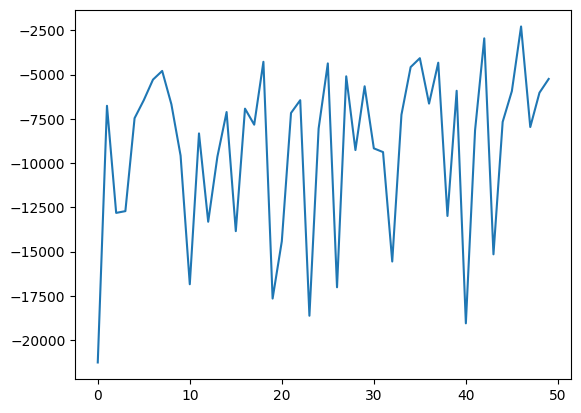

In [ ]:
plt.plot(agent.get_validation_score())
plt.show()

In [ ]:
agent.load(suffix="_best")

... loading Policy_best ...
... loading Baseline_best ...


(PolicyNet(
   (fcin): Linear(in_features=1, out_features=512, bias=True)
   (fc1): Linear(in_features=512, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=512, bias=True)
   (fcout): Linear(in_features=512, out_features=2, bias=True)
   (fctest): Linear(in_features=1, out_features=2, bias=True)
   (drp): Dropout(p=0.2, inplace=False)
 ),
 BaselineNet(
   (fcin): Linear(in_features=1, out_features=512, bias=True)
   (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc1): Linear(in_features=512, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=512, bias=True)
   (fcout): Linear(in_features=512, out_features=1, bias=True)
   (drp): Dropout(p=0.2, inplace=False)
 ))

In [ ]:
p, _ = agent.export()

In [ ]:
p(T.tensor([0.3]).to(p.device))

tensor([0.1268, 0.0879], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)

Do Not Run Cells Below (Unless you know what you are doing)

In [ ]:
optiondata = pd.read_csv("./AAPL_option.csv",dtype={"Strike":float})
display(optiondata)
equitydata = pd.read_csv("gs://hightouch-test-data/adjusted_equity_history_2019_1_to_2022_10.csv")
display(equitydata)

,TradeDate,Ticker,CallPut,Strike,ExpirationDate,OpenPrice,HighPrice,LowPrice,ClosePrice,LastBid,LastAsk,MarketHoursVolume,OpenInterest,SecId
0,2019-01-16,AAPL,P,220.00,2021-06-18,0.00,68.27,0.0,0.0,66.00,71.00,2,0,33449
1,2019-01-16,AAPL,P,200.00,2021-06-18,0.00,0.00,0.0,0.0,49.55,54.50,0,0,33449
2,2019-01-16,AAPL,C,240.00,2021-06-18,0.00,0.00,0.0,0.0,3.40,8.00,0,9,33449
3,2019-01-16,AAPL,P,115.00,2021-06-18,0.00,7.80,0.0,0.0,5.50,9.50,3,0,33449
4,2019-01-16,AAPL,C,110.00,2021-06-18,0.00,0.00,0.0,0.0,50.00,55.00,0,1,33449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153977,2021-06-17,AAPL,C,40.00,2021-06-18,0.00,92.05,0.0,0.0,91.70,91.85,7,105,33449
153978,2021-06-17,AAPL,P,105.00,2021-06-18,0.01,0.01,0.0,0.0,0.00,0.01,24,25034,33449
153979,2021-06-17,AAPL,C,46.25,2021-06-18,0.00,85.74,0.0,0.0,85.45,86.35,34,313,33449
153980,2021-06-17,AAPL,P,225.00,2021-06-18,0.00,0.00,0.0,0.0,93.15,93.30,0,1,33449


,TradeDate,SecId,Ticker,OpenPrice,HighPrice,LowPrice,ClosePrice,MarketHoursVolume,PriceAdjFactor,VolumeAdjFactor
0,2018-09-04,32952,A,65.2436,65.4568,64.7689,65.1758,1636288,0.968869,1.0
1,2018-09-05,32952,A,65.1855,65.3018,64.6817,64.8755,1680793,0.968869,1.0
2,2018-09-04,4920498,AA,43.4626,43.4824,42.6999,42.9475,1996855,0.990488,1.0
3,2018-09-05,4920498,AA,42.7594,42.7594,41.2340,42.4622,3297459,0.990488,1.0
4,2018-09-04,5628473,AAAU,0.0000,11.9400,11.9100,0.0000,6289,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
10153109,2019-08-29,69504,ZYXI,7.9382,8.2442,7.9472,8.0912,134466,0.900027,1.0
10153110,2019-08-30,69504,ZYXI,8.1452,8.2262,7.9652,8.0462,89101,0.900027,1.0
10153111,2019-09-03,69504,ZYXI,8.0642,8.1002,7.7762,7.9832,98822,0.900027,1.0
10153112,2019-09-04,69504,ZYXI,7.9832,8.3073,7.9022,8.2442,136980,0.900027,1.0


In [ ]:
agent = Agent(1,1)
agent.reset()

       Unnamed: 0  TradeDate Ticker CallPut  Strike ExpirationDate  OpenPrice  \
0               2 2019-01-16   AAPL       C  240.00     2021-06-18        0.0   
1               4 2019-01-16   AAPL       C  110.00     2021-06-18        0.0   
2               5 2019-01-16   AAPL       C  160.00     2021-06-18        0.0   
3               6 2019-01-16   AAPL       C  105.00     2021-06-18        0.0   
4               7 2019-01-16   AAPL       C  290.00     2021-06-18        0.0   
...           ...        ...    ...     ...     ...            ...        ...   
38732       77465 2021-06-21   AAPL       C  147.00     2021-06-18        0.0   
38733       77466 2021-06-21   AAPL       C   43.75     2021-06-18        0.0   
38734       77470 2021-06-21   AAPL       C   57.50     2021-06-18        0.0   
38735       77471 2021-06-21   AAPL       C  110.00     2021-06-18        0.0   
38736       77473 2021-06-21   AAPL       C  160.00     2021-06-18        0.0   

       HighPrice  LowPrice 

Fetch Data --

In [ ]:
data = fetch_option("AAPL", preprocess=lambda df: df[df['ExpirationDate']=="2021-06-18"])
# data = pd.read_csv("./tmpdata.csv").drop(columns=['Unnamed: 0'])
data = data[data["TradeDate"] < data["ExpirationDate"]]

In [ ]:
display(data)

,TradeDate,Ticker,CallPut,Strike,ExpirationDate,OpenPrice,HighPrice,LowPrice,ClosePrice,LastBid,LastAsk,MarketHoursVolume,OpenInterest,SecId
0,2019-01-16,AAPL,P,220.00,2021-06-18,0.00,68.27,0.0,0.0,66.00,71.00,2,0,33449
1,2019-01-16,AAPL,P,200.00,2021-06-18,0.00,0.00,0.0,0.0,49.55,54.50,0,0,33449
2,2019-01-16,AAPL,C,240.00,2021-06-18,0.00,0.00,0.0,0.0,3.40,8.00,0,9,33449
3,2019-01-16,AAPL,P,115.00,2021-06-18,0.00,7.80,0.0,0.0,5.50,9.50,3,0,33449
4,2019-01-16,AAPL,C,110.00,2021-06-18,0.00,0.00,0.0,0.0,50.00,55.00,0,1,33449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76986,2021-06-17,AAPL,C,40.00,2021-06-18,0.00,92.05,0.0,0.0,91.70,91.85,7,105,33449
76987,2021-06-17,AAPL,P,105.00,2021-06-18,0.01,0.01,0.0,0.0,0.00,0.01,24,25034,33449
76988,2021-06-17,AAPL,C,46.25,2021-06-18,0.00,85.74,0.0,0.0,85.45,86.35,34,313,33449
76989,2021-06-17,AAPL,P,225.00,2021-06-18,0.00,0.00,0.0,0.0,93.15,93.30,0,1,33449


In [ ]:
data.to_csv("AAPL_option.csv",index=False)